# Creates gif of the evolution of the training process
The plot contains two subplots
- Level sets of the predictions of the model at epoch
- Loss at epoch

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

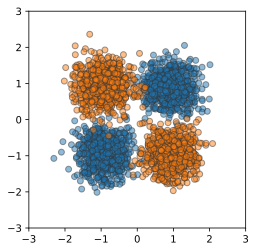

In [2]:
data_noise = 0.2
plotlim = [-3, 3]
subfolder = 'evo_xor'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('xor', noise = data_noise, plotlim = plotlim)


In [3]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[ 0.7012, -0.6099],
        [-1.0771, -1.0843],
        [ 0.6257, -0.6414],
        [-1.0108, -0.9732],
        [-1.0886,  0.7414],
        [-1.1147,  0.6808],
        [-0.4920, -1.1440],
        [ 1.1274, -0.6307],
        [-1.5157,  0.8518],
        [-0.1234, -1.0121]]) tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 0])


# Model dynamics

In [4]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5, 5 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(2)
torch.cuda.manual_seed(2)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


In [5]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 


print(rnode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


# Training and generating level sets

In [6]:
from models.training import Trainer, doublebackTrainer
from plots.plots import train_to_classifier_imgs

num_epochs = 10 #number of optimization runs in which the dataset is used for gradient decent
plotfreq = 5

eps = 0.3

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = eps) 

   
train_to_classifier_imgs(anode, trainer_anode, dataloader, subfolder, num_epochs, plotfreq)

0.3

Iteration 0/45
Loss: 0.895
Robust Term Loss: 0.261
Accuracy: 0.562

Iteration 10/45
Loss: 0.972
Robust Term Loss: 0.268
Accuracy: 0.578

Iteration 20/45
Loss: 0.836
Robust Term Loss: 0.227
Accuracy: 0.547

Iteration 30/45
Loss: 0.766
Robust Term Loss: 0.207
Accuracy: 0.562

Iteration 40/45
Loss: 0.683
Robust Term Loss: 0.180
Accuracy: 0.656
Epoch 1: 0.777
0.3

Iteration 0/45
Loss: 0.747
Robust Term Loss: 0.188
Accuracy: 0.516

Iteration 10/45
Loss: 0.789
Robust Term Loss: 0.199
Accuracy: 0.531

Iteration 20/45
Loss: 0.726
Robust Term Loss: 0.170
Accuracy: 0.484

Iteration 30/45
Loss: 0.694
Robust Term Loss: 0.152
Accuracy: 0.453

Iteration 40/45
Loss: 0.637
Robust Term Loss: 0.142
Accuracy: 0.578
Epoch 2: 0.697
0.3

Iteration 0/45
Loss: 0.685
Robust Term Loss: 0.148
Accuracy: 0.531

Iteration 10/45
Loss: 0.711
Robust Term Loss: 0.159
Accuracy: 0.469

Iteration 20/45
Loss: 0.669
Robust Term Loss: 0.140
Accuracy: 0.531

Iteration 30/45
Loss: 0.647
Robust Term Loss: 0.124
Accuracy: 0

In [7]:
from models.training import Trainer, doublebackTrainer

trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps) 



train_to_classifier_imgs(rnode, trainer_rnode, dataloader, subfolder, num_epochs, plotfreq, filename = 'rob')

0.3

Iteration 0/45
Loss: 0.887
Robust Term Loss: 0.261
Accuracy: 0.562

Iteration 10/45
Loss: 0.951
Robust Term Loss: 0.267
Accuracy: 0.578

Iteration 20/45
Loss: 0.813
Robust Term Loss: 0.225
Accuracy: 0.562

Iteration 30/45
Loss: 0.738
Robust Term Loss: 0.203
Accuracy: 0.594

Iteration 40/45
Loss: 0.651
Robust Term Loss: 0.174
Accuracy: 0.672
Epoch 1: 0.755
0.3

Iteration 0/45
Loss: 0.702
Robust Term Loss: 0.181
Accuracy: 0.531

Iteration 10/45
Loss: 0.738
Robust Term Loss: 0.189
Accuracy: 0.547

Iteration 20/45
Loss: 0.663
Robust Term Loss: 0.159
Accuracy: 0.531

Iteration 30/45
Loss: 0.621
Robust Term Loss: 0.139
Accuracy: 0.484

Iteration 40/45
Loss: 0.574
Robust Term Loss: 0.128
Accuracy: 0.594
Epoch 2: 0.637
0.3

Iteration 0/45
Loss: 0.607
Robust Term Loss: 0.131
Accuracy: 0.531

Iteration 10/45
Loss: 0.627
Robust Term Loss: 0.137
Accuracy: 0.469

Iteration 20/45
Loss: 0.585
Robust Term Loss: 0.119
Accuracy: 0.516

Iteration 30/45
Loss: 0.559
Robust Term Loss: 0.103
Accuracy: 0

# Loss plots

trainer_rnode.eps = 0.3
epoch = 0


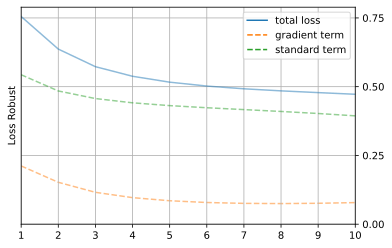

no filename given


In [8]:
from enum import auto

from plots.plots import loss_evolution
print(f'{trainer_rnode.eps = }')
loss_evolution(trainer_rnode, 0)

epoch = 5


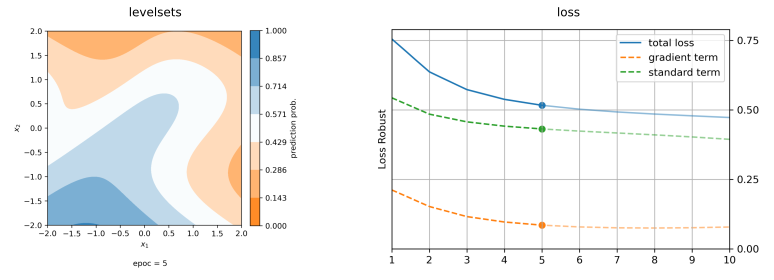

In [9]:
from plots.plots import comparison_plot
import os

epoch = 5
fig_name_base = os.path.join(subfolder, '')
loss_evolution(trainer_rnode, epoch, 'loss_pic')
comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'test', show = True, figsize = (12,4))

## gif generation

In [10]:
from plots.gifs import evo_gif
gif = evo_gif(trainer_anode, num_epochs, plotfreq, subfolder, '', keep = [5,10])

5
epoch = 5
10
epoch = 10
evo_xor/evo.gif  created


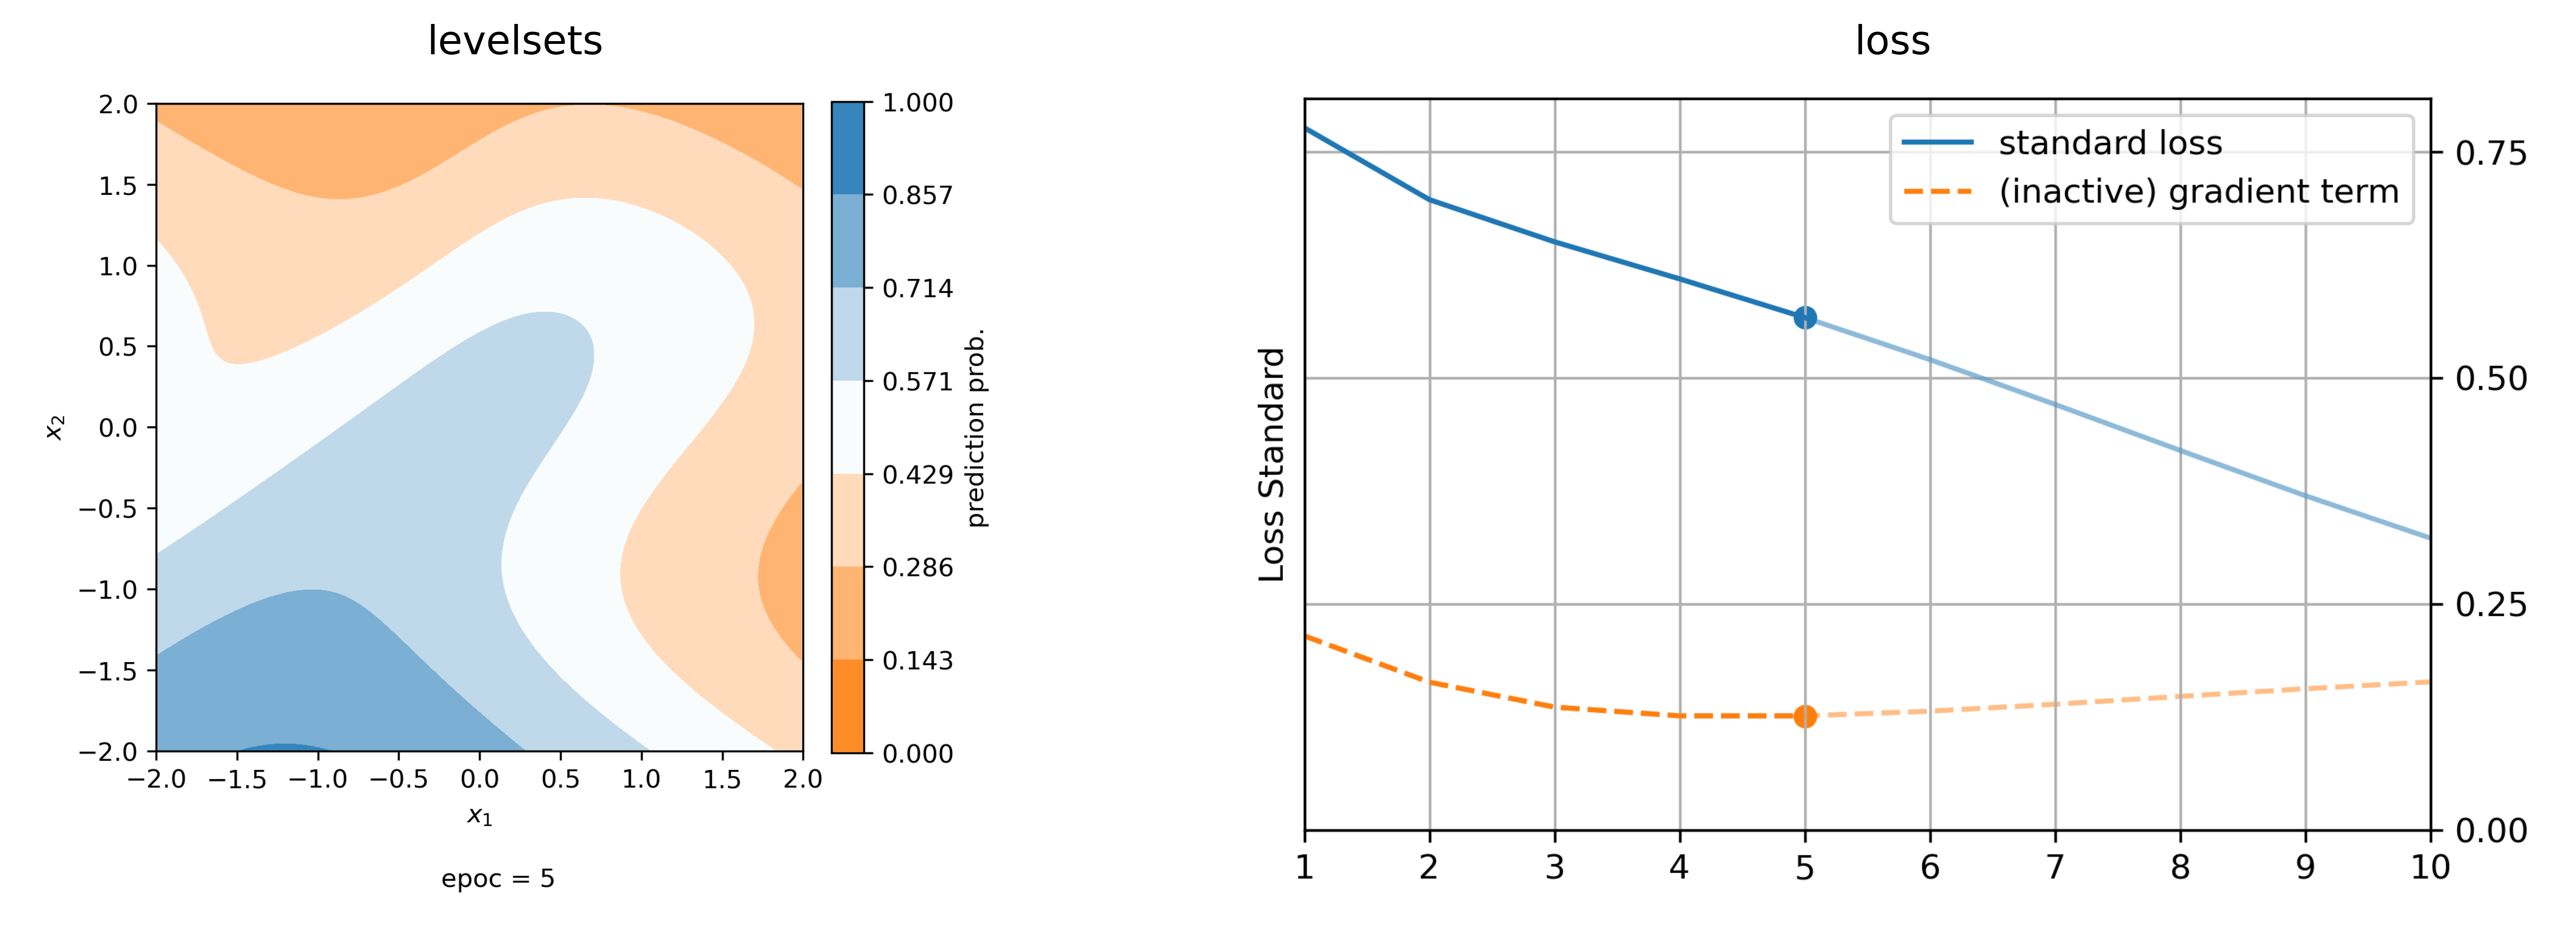

In [11]:
from IPython.display import Image
Image(filename = gif, width = 800)

5
epoch = 5
10
epoch = 10
evo_xor/robevo.gif  created


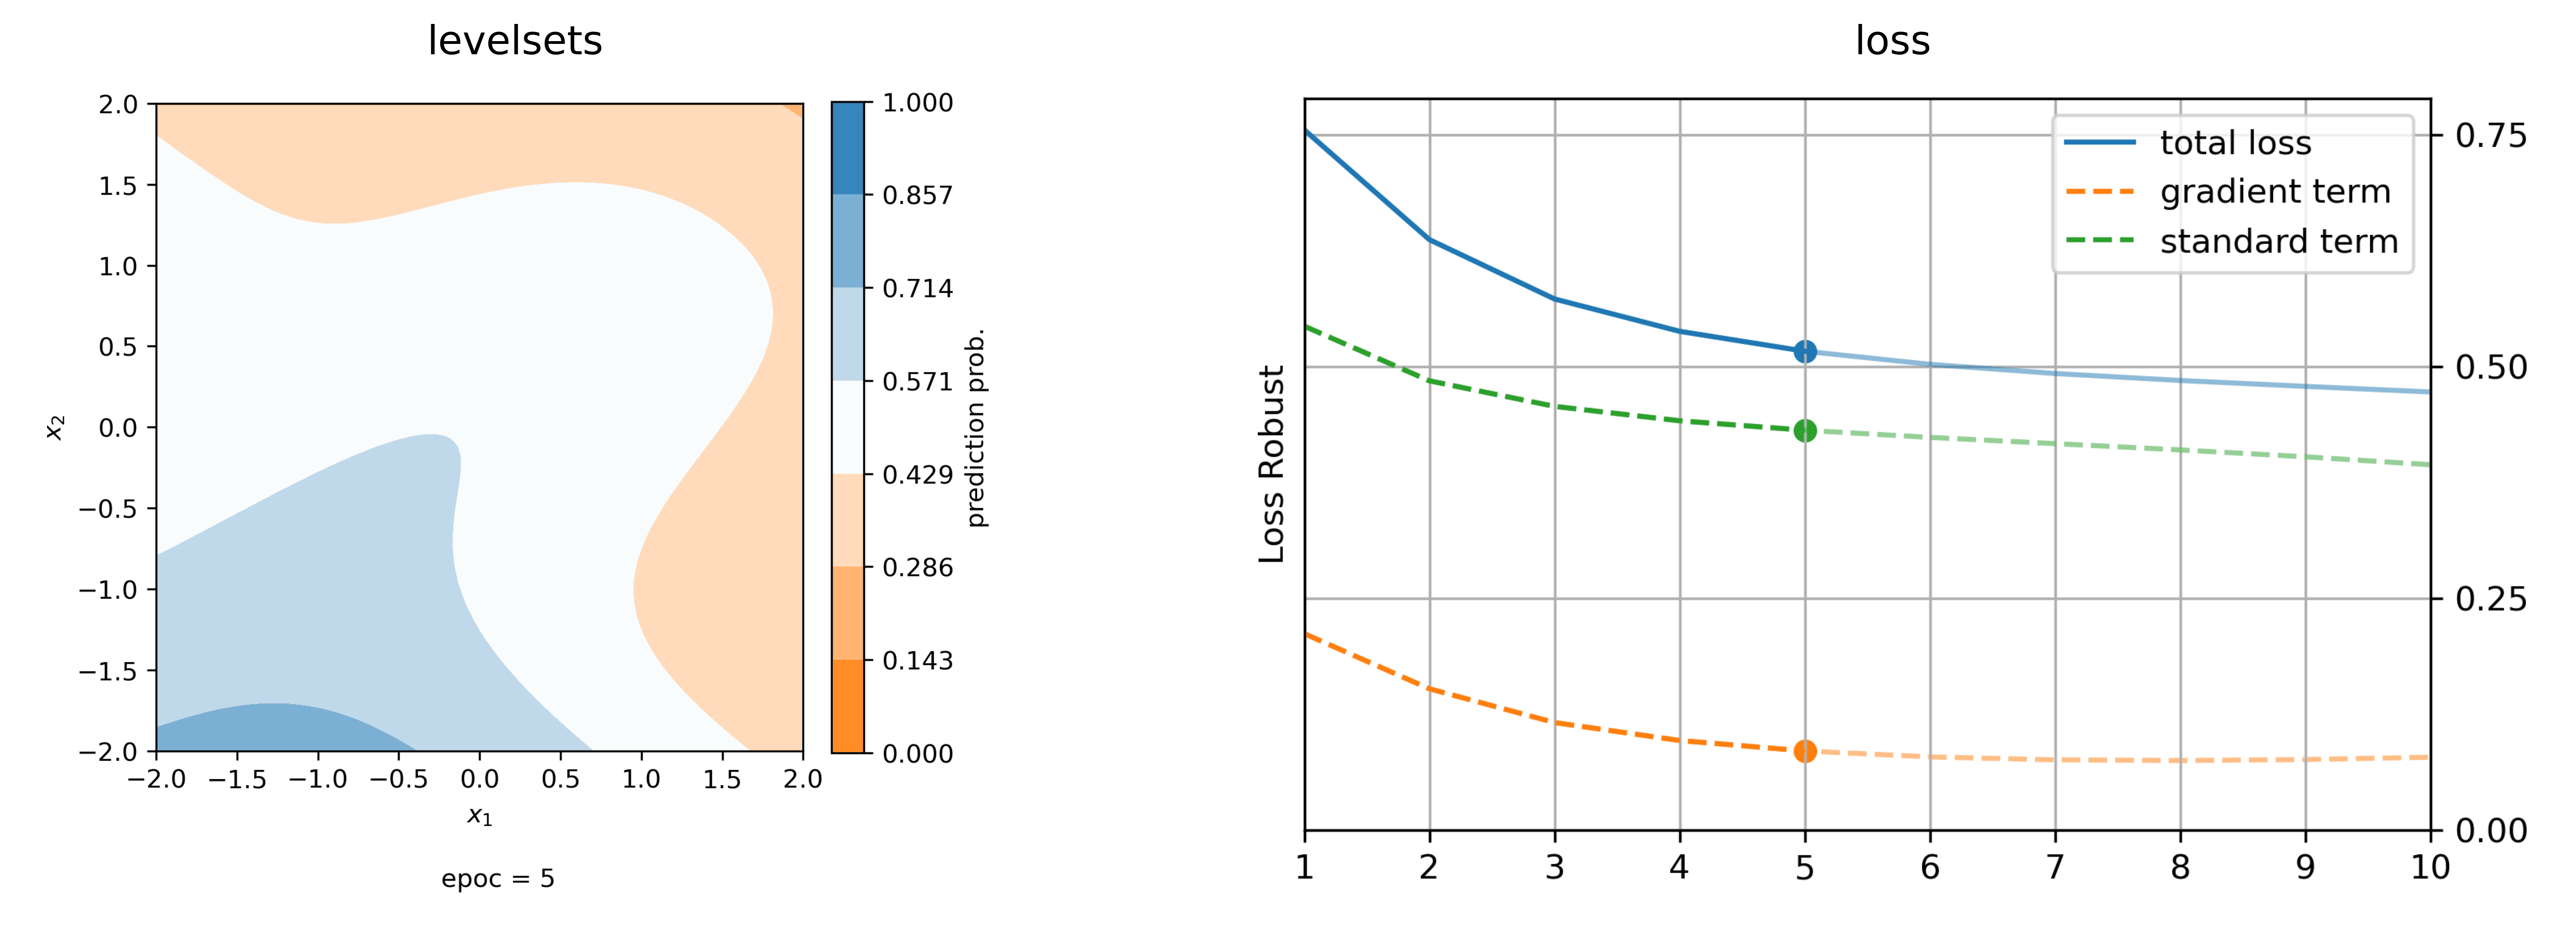

In [12]:
rob_gif = evo_gif(trainer_rnode, num_epochs, plotfreq, subfolder, 'rob')

from IPython.display import Image
Image(filename = rob_gif, width = 800)